*Реализация модели GCN применительно к этому графу коммуникаций Reddit для классификации вершин графа*

#Загрузка библиотеки

In [43]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Reddit
from torch_geometric.nn import GCNConv
from torch_geometric.utils import subgraph, to_networkx
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Загрузка датасета

In [41]:
dataset = Reddit(root='/tmp/Reddit')
data = dataset[0]

# Создаем подграф
subset = torch.arange(10000, device=data.edge_index.device)
edge_index, _ = subgraph(subset, data.edge_index, relabel_nodes=True)
x, y = data.x[subset], data.y[subset]

# Разделение
train_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[:8000] = True  # 80% train
val_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask[8000:9000] = True  # 10% val
test_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask[9000:] = True  # 10% test

#Визуал

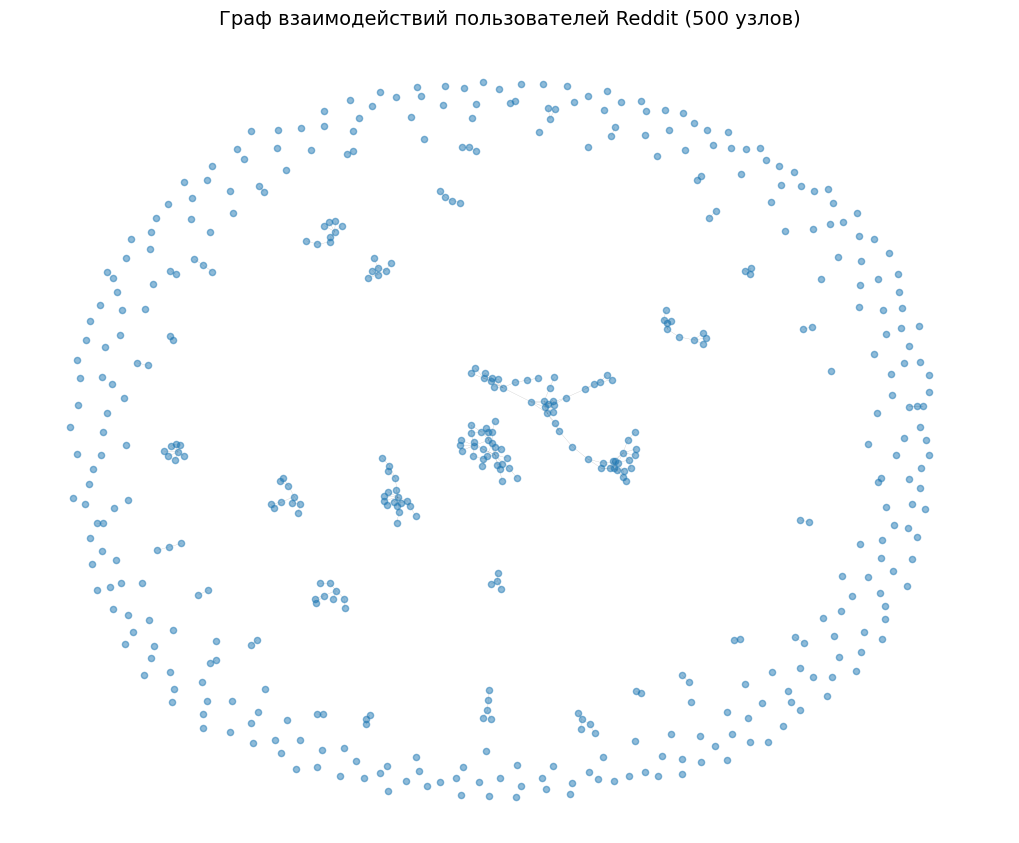

In [50]:
small_subset = torch.arange(500, device=data.edge_index.device)
small_edge_index, _ = subgraph(small_subset, data.edge_index, relabel_nodes=True)
G = to_networkx(Data(edge_index=small_edge_index, num_nodes=500), to_undirected=True)
plt.figure(figsize=(10, 8))
nx.draw_spring(G, node_size=20, width=0.1, alpha=0.5, with_labels=False)
plt.title("Граф взаимодействий пользователей Reddit (500 узлов)", fontsize=14)
plt.show()

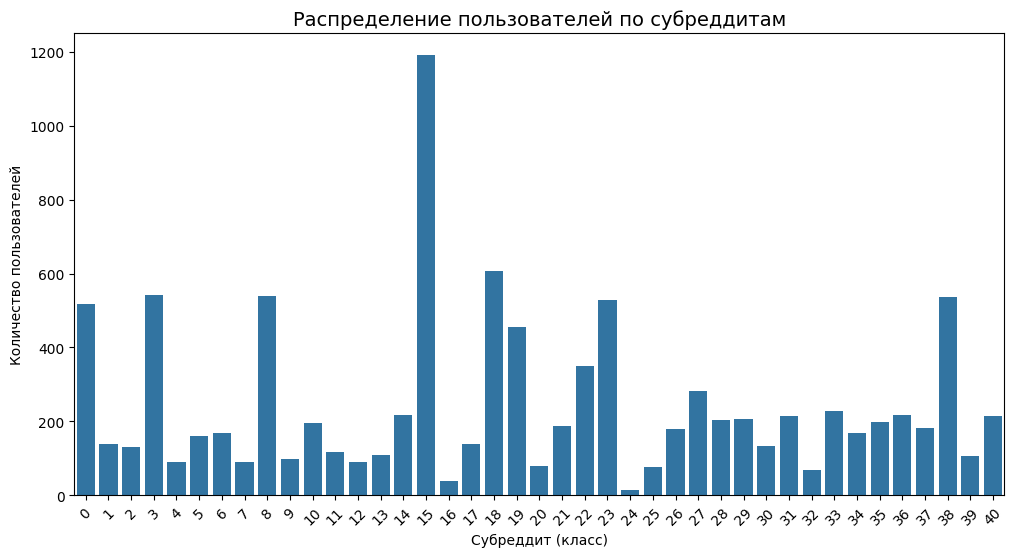

In [49]:
plt.figure(figsize=(12, 6))
sns.countplot(x=y.cpu().numpy())
plt.xlabel("Субреддит (класс)")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по субреддитам", fontsize=14)
plt.xticks(rotation=45)
plt.show()


#Обучение модели

In [52]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=128, num_features=data.num_features, num_classes=y.unique().size(0))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [53]:
train_losses = []
val_accuracies = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = F.nll_loss(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(x, edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        accs.append(accuracy_score(y[mask].cpu(), pred[mask].cpu()))
    return accs

for epoch in range(1, 101):
    loss = train()
    train_losses.append(loss)
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        val_accuracies.append(val_acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch: 010, Loss: 1.0465, Val Acc: 0.82
Epoch: 020, Loss: 0.5514, Val Acc: 0.88
Epoch: 030, Loss: 0.3900, Val Acc: 0.89
Epoch: 040, Loss: 0.3077, Val Acc: 0.90
Epoch: 050, Loss: 0.2509, Val Acc: 0.90
Epoch: 060, Loss: 0.2245, Val Acc: 0.90
Epoch: 070, Loss: 0.2096, Val Acc: 0.90
Epoch: 080, Loss: 0.1900, Val Acc: 0.90
Epoch: 090, Loss: 0.1846, Val Acc: 0.90
Epoch: 100, Loss: 0.1722, Val Acc: 0.90


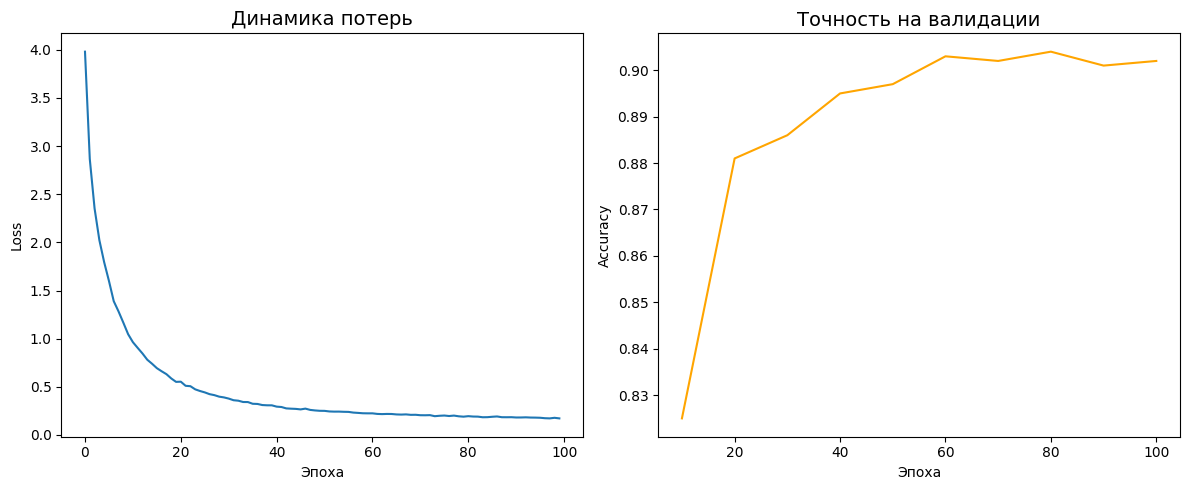

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Потери')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика потерь', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(10, 101, 10), val_accuracies, label='Точность', color='orange')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Точность на валидации', fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x[train_mask].cpu().numpy(), y[train_mask].cpu().numpy())
rf_acc = accuracy_score(y[test_mask].cpu(), rf.predict(x[test_mask].cpu().numpy()))

# MLP
mlp = torch.nn.Sequential(
    torch.nn.Linear(data.num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, y.unique().size(0))
)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01)

for epoch in range(100):
    optimizer_mlp.zero_grad()
    out = mlp(x[train_mask])
    loss = F.cross_entropy(out, y[train_mask])
    loss.backward()
    optimizer_mlp.step()

mlp_acc = accuracy_score(y[test_mask].cpu(), mlp(x[test_mask]).argmax(dim=1).cpu())

print(f"GCN Test Accuracy: {test_acc:.2f}")
print(f"Random Forest Test Accuracy: {rf_acc:.2f}")
print(f"MLP Test Accuracy: {mlp_acc:.2f}")

GCN Test Accuracy: 0.89
Random Forest Test Accuracy: 0.42
MLP Test Accuracy: 0.59


#Потенциал модели

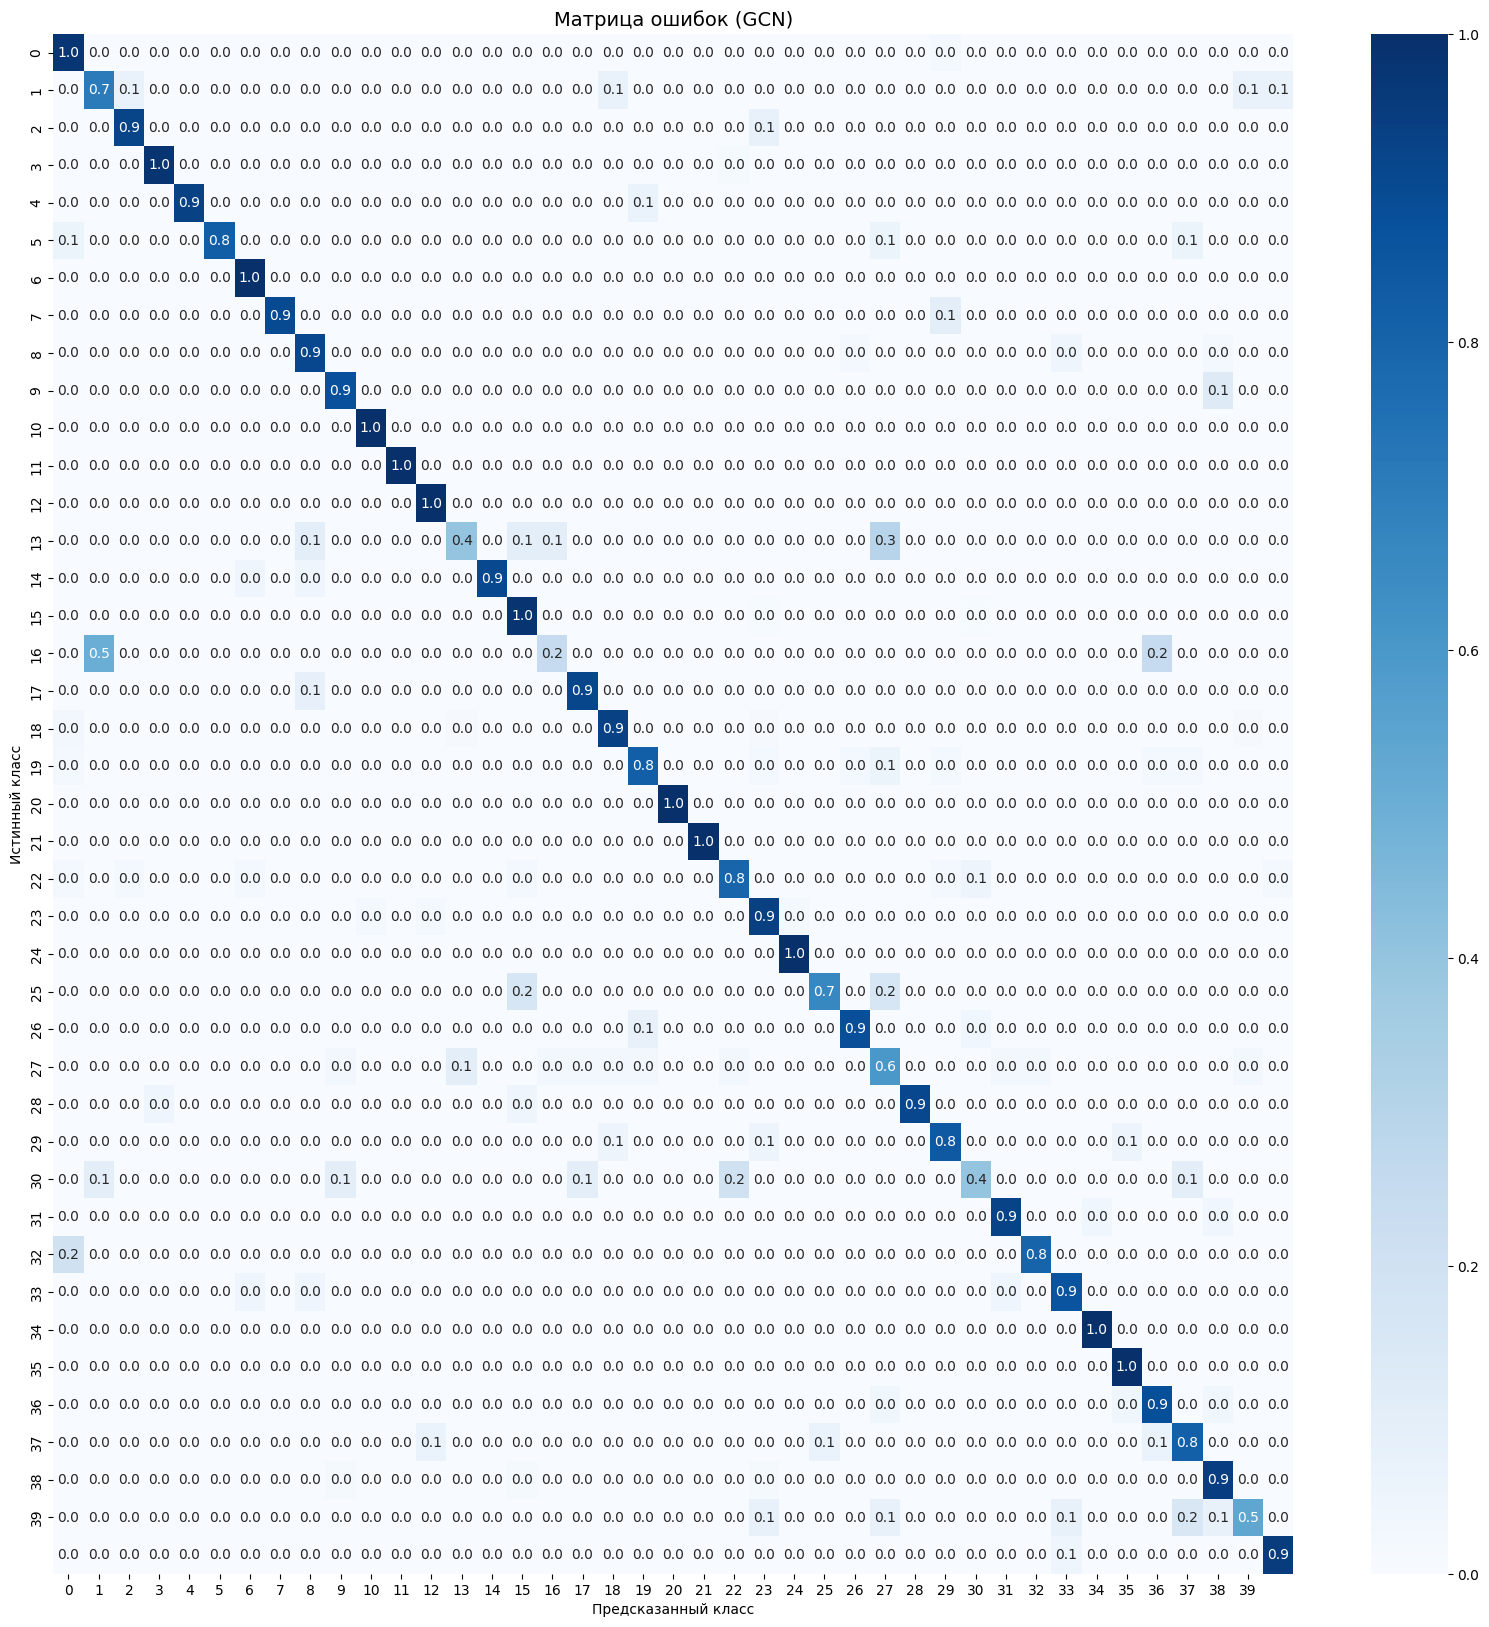

In [64]:
model.eval()
pred = model(x, edge_index).argmax(dim=1)[test_mask].cpu()
true = y[test_mask].cpu()

cm = confusion_matrix(true, pred, normalize='true')
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=range(40), yticklabels=range(40))
plt.title('Матрица ошибок (GCN)', fontsize=14)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()